## introduction
### problem statement
Every day always more people experience the opportunity of training overywhere: outdoor on a park, in a garage, in our bedroom etc. Anyway this possibility of freedom led to a great issue commont to every uncommon athlets: the lack of feedbacks.
infact, while in a gym is easy receive a examination on own exercise esecution, by a trainer or by another athlet, on own bedroom we don't have this possibility. lack of feedback on exercise esecution led to learn improper esecutin, bring to weak performances, injuries etc

### state of art 
to evaluete own proper execution, athlets sometimes use to record their performarce in order to self esaminate them and find what is wrong. Anyway this process is tedios becouse it involve the need to find a good place to put the smartphone,record the clip, skip all the preparation of exercise, find the most significative point on the esecution, examinate them and finaly understaining whats wrong for correcting mistakes on the next repetition.
Do this proces for every rep, for every exercise, in time with rest time (usualy in the order of 1 minute), can be annoing and most athlets preferes to not be distracted and keep attention on their work out.

### proposed solution 
my idea is to make all this process agile for the atlets, developing a computer vision pipeline that is able  to take the recordered clip, extrapolate the most important keyframe for the athlets, discard all the unnecessary moment to be keep user attention on the most important moment and give to final user a edited clipp to fast evaluate own performances


# Step O colab initialization

In [1]:
!git clone https://github.com/AlfaranoAndrea/workuout_keyframe.git
%cd workuout_keyframe 
!gdown https://drive.google.com/drive/folders/148Mhwpt9E89_gLMAJC4S45DiVv83Xz54?usp=share_link --folder -O input_video


Cloning into 'workuout_keyframe'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 131 (delta 49), reused 98 (delta 38), pack-reused 4
Receiving objects: 100% (131/131), 5.67 MiB | 10.07 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/workuout_keyframe
Retrieving folder list
Processing file 1KC4dLg3R-RVVxKlEeXwidfX6CMcALzEX military.mp4
Processing file 1VMJWvQ_dWtwkw6uaQUAV8s8zrFE1n6u6 poor_execution.mp4
Processing file 1DILeSomSV_LVZK6O_LSDVQ7yhz52KDE_ pullup.mp4
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1KC4dLg3R-RVVxKlEeXwidfX6CMcALzEX
To: /content/workuout_keyframe/input_video/military.mp4
100% 58.5M/58.5M [00:00<00:00, 60.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VMJWvQ_dWtwkw6uaQUAV8s8zrFE1n6u6
To: /content/workuout_keyframe/input_video/po

In [3]:
!wget -h

GNU Wget 1.20.3, a non-interactive network retriever.
Usage: wget [OPTION]... [URL]...

Mandatory arguments to long options are mandatory for short options too.

Startup:
  -V,  --version                   display the version of Wget and exit
  -h,  --help                      print this help
  -b,  --background                go to background after startup
  -e,  --execute=COMMAND           execute a `.wgetrc'-style command

Logging and input file:
  -o,  --output-file=FILE          log messages to FILE
  -a,  --append-output=FILE        append messages to FILE
  -d,  --debug                     print lots of debugging information
  -q,  --quiet                     quiet (no output)
  -v,  --verbose                   be verbose (this is the default)
  -nv, --no-verbose                turn off verboseness, without being quiet
       --report-speed=TYPE         output bandwidth as TYPE.  TYPE can be bits
  -i,  --input-file=FILE           download URLs found in local or external FILE
  

In [4]:
%cd models
!mkdir checkpoint
%cd checkpoint
!wget "drive.google.com/u/3/uc?id=1iAKv2S1OE3YpwgwX43bKZHxBAlluL9Y9&export=download&confirm=yes" -O flownets.pth.tar.pth

/content/workuout_keyframe/models
/content/workuout_keyframe/models/checkpoint
URL transformed to HTTPS due to an HSTS policy
--2023-02-16 16:14:23--  https://drive.google.com/u/3/uc?id=1iAKv2S1OE3YpwgwX43bKZHxBAlluL9Y9&export=download&confirm=yes
Resolving drive.google.com (drive.google.com)... 142.250.141.100, 142.250.141.113, 142.250.141.139, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.100|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1iAKv2S1OE3YpwgwX43bKZHxBAlluL9Y9&export=download&confirm=yes [following]
--2023-02-16 16:14:23--  https://drive.google.com/uc?id=1iAKv2S1OE3YpwgwX43bKZHxBAlluL9Y9&export=download&confirm=yes
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-44-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7vu9o9heo55euolrq3bmdd5qto92c739/1676564025000/06430227796893093141/*/1

In [ ]:
!python3 downloadSintel.py

############### DOWNLOADING SINTEL DATA ###############
5.50MKB [03:39, 25.0kKB/s]               
############### UNZIPPING SINTEL DATA ###############
############### COMPLETE UNZIPPING DATA ###############


In [ ]:
!pip install pytorch_lightning --quiet
!pip install flowiz --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.2/826.2 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 KB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 KB 23.0 MB/s eta 0:00:00


# First part: Deep Learning

In [ ]:
import numpy as np
import torch
import pytorch_lightning as pl

from torchvision import datasets
import matplotlib.pyplot as plt
import flowiz as fz

from dataset import  FlowDataModule
from models.flowNetS import FlowNetS
from models.raft import RAFT

from utilities.videoUtilities import extract_frames, saveVideo
from utilities.flowUtilities import computeFlow, flowVideo
from utilities.keyFramesUtilities import find_center_of_gravity, save_key_frames
from utilities.signalUtilities import  moving_average, findKeyPoints

# datasets

let's visualize how torch vison dataset FlyingChairs works

In [ ]:
loadedDataset= datasets.Sintel(root='./dataset',
                              split = "train", 
                              #transforms = dataModulo.dataset_transformation,
                              pass_name = "clean"
                                )

image1 in dataset has shape: (436, 1024, 3)
image2 in dataset has shape: (436, 1024, 3)
flow image in dataset has shape: (2, 436, 1024)
flow image in dataset has this new shape: (436, 1024, 2)


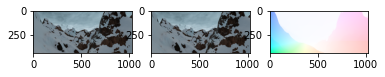

In [ ]:
"""
dataset gives back triplets [image1,image2, targetFlow]
"""

triplet=loadedDataset[10]
img1,img2,flow= triplet

img1=np.asarray(img1)
img2=np.asarray(img2)

print (f"image1 in dataset has shape: {img1.shape}")
print (f"image2 in dataset has shape: {img2.shape}")

print (f"flow image in dataset has shape: {flow.shape}")
flow=np.transpose (flow,(1,2,0))
print (f"flow image in dataset has this new shape: {flow.shape}")

flow=fz.convert_from_flow(flow) 

plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.subplot(1, 3, 3)
plt.imshow(flow)



## model training

In [ ]:
#save = torch.load("./models/checkpoint/flownets.pth.tar.pth")#["state_dict"]
model  = RAFT(version="large")
data=FlowDataModule(batch_size =1, workers=32,selected_dataset ="Sintel")

trainer = pl.Trainer(accelerator= "gpu" if torch.cuda.is_available() else "cpu", 
                     max_epochs=20,             
                     auto_lr_find=False, 
                     auto_scale_batch_size=False)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
#trainer.fit(model,data )
#trainer.test(model, data)

# Second part: Computing Pipeline

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model  = RAFT()
model.to(device)
video_path= "./input_video/pullup.mp4"
temp_extracted_frames="./temp/Frames/"
temp_processed_flow_frames="./temp/processedFloFrames/"

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
fps=30
fps=int(extract_frames(video_path))
flowVideo(
    path=temp_extracted_frames,
    model=model,
    device=device)
saveVideo(temp_processed_flow_frames,"pippo", fps=fps)
   

  2%|▏         | 22/1032 [01:54<1:26:33,  5.14s/it]

In [ ]:
# 3B- Find miving cordinates of center of gravity of our athlet
x,y=find_center_of_gravity(temp_processed_flow_frames)  
#saveVideo(comp,"PullUp_mass",bw=True)

## SIGNAL ANALISYS

In [ ]:
fig, ax = plt.subplots()
ax.plot(y)
plt.show()

In [ ]:
# 2- mobile average
#K=[0.25,0.25,0.25,0.25]


#avg=np.convolve(K,y)
avg=moving_average(y,k=30)
fig, ax = plt.subplots()
ax.plot(avg)
plt.show()

In [ ]:
# 3- find peacks positive
peaks= findKeyPoints(avg)


np.diff(peaks)
plt.figure(figsize=(15,10))
plt.plot(avg)
plt.plot(peaks, avg[peaks], "x")
plt.show()


In [ ]:
save_key_frames(
    keyFramesList=peaks, 
    frames_path=temp_extracted_frames,
    threshold=12, 
    near=5, 
    slowmotion=2, 
    speedUp=4, 
    title="final.avi")
#saveVideo(video,"video_allenamento_pullup", frames_rate=60)